In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

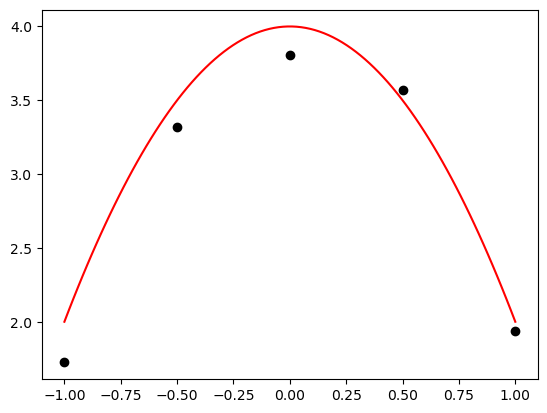

In [14]:
# Simulate data.
RANDOM_SEED = 10 
rng = np.random.default_rng(RANDOM_SEED)

# True function. 
g = lambda x : 4 - 2*np.power(x,2)

sig = 0.25 
n_design = 5
n_test = 100
X_design = np.linspace(-1, 1, num=n_design)[:, None]
X_test = np.linspace(-1, 1, num=n_test)[:, None]
g_test = g(X_test)
y_design = g(X_design)[:,0] + rng.normal(loc=0, scale=sig, size=n_design)

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.show()

# sig = 0.25
# par_true = 1.0
# n_obs = 10
# time_steps = np.linspace(start=0, stop=10, num=400)
# time_steps_obs = np.linspace(start=0, stop=10, num=n_obs)
# g_dense = lambda u : u * np.cos(np.pi*time_steps/2)
# g = lambda u : u * np.cos(np.pi*time_steps_obs/2)
# g_true_dense = g_dense(par_true)
# g_true = g(par_true)
# y = g_true + rng.normal(loc=0, scale=sig, size=n_obs)

# plt.plot(time_steps, g_true_dense)
# plt.plot(time_steps_obs, y, "ro")
# plt.show()


In [3]:
# Define GP mean/covariance functions. 

# Kernel. 
ell_true = 1.0
eta_true = 4.0
cov_func = pm.gp.cov.Polynomial(1, c=0, d=2, offset=1)

# cov_func = eta_true**2 * (pm.gp.cov.ExpQuad(1, ell_true) + pm.gp.cov.Polynomial(1, 0, 2, 1))

# Mean function. 
mean_func = pm.gp.mean.Zero()

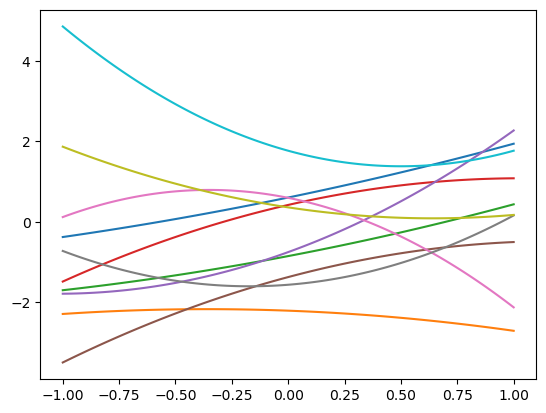

In [4]:
# Sample from GP prior. 
prior_draws = pm.draw(pm.MvNormal.dist(mu=mean_func(X_test), cov=cov_func(X_test)), 10, random_seed=rng)

plt.plot(X_test, np.transpose(prior_draws))
plt.show()

In [32]:
# Fit hyperparameters. Note that the marginal GP model 
# simply means a GP with Gaussian noise, so that the GP 
# can be analytically marginalized. The latent GP implementation 
# is more of a standalone GP that can be incorporated into other 
# likelihoods, etc. 

# TODO: 
# - Assign 
#

with pm.Model() as marginal_gp_model:
    # Covariance. 
    cov_func = pm.gp.cov.Polynomial(1, c=0, d=2, offset=1)

    # Mean function. 
    mean_func = pm.gp.mean.Zero()

    # Specify the GP..
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Fix the observation noise. This can alternatively be assigned a prior.  
    sigma = sig # pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X_design, y=y_design, sigma=sigma)

    # Predict. Don't think this needs to be within the "with" environment. 
    mu, Cov = gp.predict(Xnew=X_test)

    # Alternatively, we can form the conditional GP which can then be used for prediction. 
    # This object can then be used in posterior predictive sampling, etc. 
    gp_cond = gp.conditional("gp_cond", Xnew=X_test, pred_noise=False)

TypeError: sample_posterior_predictive() missing 1 required positional argument: 'trace'

In [31]:
# Attributes of model object. 
print(marginal_gp_model.basic_RVs)
print(marginal_gp_model.unobserved_RVs)
print(marginal_gp_model.value_vars)

# Appears that objects created in the "with" environment are available as global variables. 
print(type(gp))
print(type(gp_cond))

[gp_cond, y]
[gp_cond]
[gp_cond]
<class 'pymc.gp.gp.Marginal'>
<class 'pytensor.tensor.variable.TensorVariable'>
Shape.0


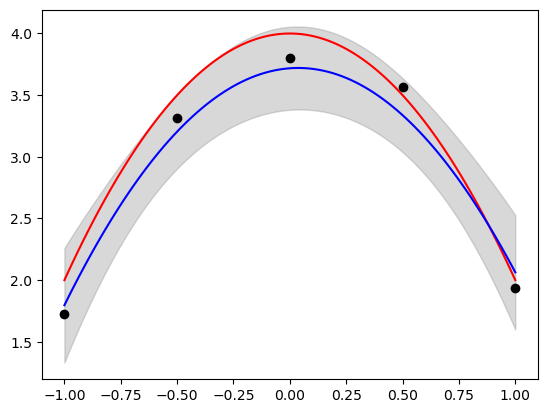

In [21]:
pred_vars = np.sqrt(np.diag(Cov))

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, mu, "b")
plt.fill_between(X_test[:,0], mu-2*pred_vars, mu+2*pred_vars, color="gray", alpha=0.3)
plt.show()

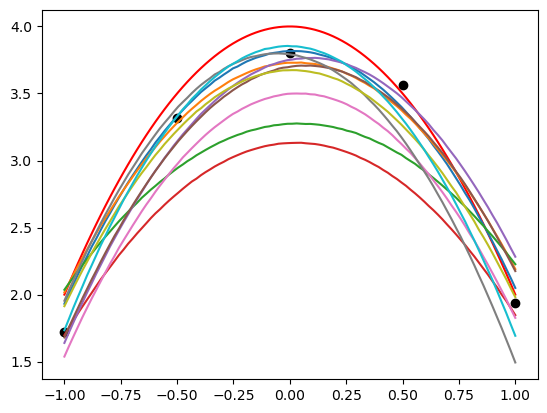

In [26]:
# Sample from GP conditional. 
cond_draws = pm.draw(pm.MvNormal.dist(mu=mu, cov=Cov), 10, random_seed=rng)

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, np.transpose(cond_draws))
plt.show()

In [109]:
# Predict on test points. Use `pred_noise` argument to specify whether to add noise 
# variance to predictions or not. 

# with marginal_gp_model:
#     

mu, Cov = pm.gp.Marginal.predict(X_test, model=marginal_gp_model)


TypeError: Marginal.predict() missing 1 required positional argument: 'Xnew'